In [31]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
from collections import defaultdict
import ast

# Load the CSV file
file_path = 'data_export.csv'
df = pd.read_csv(file_path)

# Convert relevant columns to numeric and handle missing values
df["author_h_index"] = pd.to_numeric(df["author_h_index"], errors="coerce").fillna(0)
df["journal_h_index"] = pd.to_numeric(df["journal_h_index"], errors="coerce").fillna(0)
df["num_authors"] = pd.to_numeric(df["num_authors"], errors="coerce").fillna(0)
df["num_institutions"] = pd.to_numeric(df["num_institutions"], errors="coerce").fillna(0)
df["cited_by_count"] = pd.to_numeric(df["cited_by_count"], errors="coerce").fillna(0)
df["publication_year"] = pd.to_numeric(df["publication_year"], errors="coerce").fillna(2024)

# Drop rows where cited_by_count is 0
#df = df[df["cited_by_count"] > 0]

# Apply log transformation to cited_by_count
df["log_cited_by_count"] = np.log1p(df["cited_by_count"])  # log(1 + cited_by_count)

# Calculate time since publication
df["years_since_publication"] = 2024 - df["publication_year"]

# Default dictionaries to track publication and citation counts
author_publications = defaultdict(int)
author_citations = defaultdict(int)

# Calculate total publications and citations for each author
for _, row in df.iterrows():
    if pd.notna(row["authors"]):  # Process the "authors" field
        # Parse the authors list
        authors = ast.literal_eval(row["authors"]) if isinstance(row["authors"], str) else []
        # Increment publication count and citations for each author
        for author in authors:
            author_publications[author] += 1
            author_citations[author] += row.get("cited_by_count", 0)

# Function to calculate average co-author citations excluding the focal paper
def calculate_coauthor_success(row):
    if pd.notna(row["authors"]):
        authors = ast.literal_eval(row["authors"]) if isinstance(row["authors"], str) else []
        coauthor_citations = [
            author_citations[author] - row["cited_by_count"]  # Exclude focal paper's citations
            for author in authors if author in author_citations
        ]
        if coauthor_citations:
            return sum(coauthor_citations) / len(coauthor_citations)
    return 0

# Add average co-author citations as a feature
df["avg_coauthor_citations"] = df.apply(calculate_coauthor_success, axis=1)

# Log-transform the average co-author citations to reduce skewness
df["log_avg_coauthor_citations"] = np.log1p(df["avg_coauthor_citations"])  # log(1 + avg_coauthor_citations)

# Define independent (X) and dependent (y) variables
X = df[[
    "log_avg_coauthor_citations", 
    "years_since_publication",  # Include time since publication
    "journal_h_index", 
    "num_authors", 
    "num_institutions"
]]
y = df["log_cited_by_count"]

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Fit the OLS regression model
model = sm.OLS(y, X).fit()

# Print the summary of the regression model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     log_cited_by_count   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                     2119.
Date:                Mon, 30 Dec 2024   Prob (F-statistic):               0.00
Time:                        11:29:33   Log-Likelihood:                -21037.
No. Observations:               15033   AIC:                         4.209e+04
Df Residuals:                   15027   BIC:                         4.213e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [32]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
from collections import defaultdict
import ast

# Load the CSV file
file_path = 'data_export.csv'
df = pd.read_csv(file_path)

# Convert relevant columns to numeric and handle missing values
df["author_h_index"] = pd.to_numeric(df["author_h_index"], errors="coerce").fillna(0)
df["journal_h_index"] = pd.to_numeric(df["journal_h_index"], errors="coerce").fillna(0)
df["num_authors"] = pd.to_numeric(df["num_authors"], errors="coerce").fillna(0)
df["num_institutions"] = pd.to_numeric(df["num_institutions"], errors="coerce").fillna(0)
df["cited_by_count"] = pd.to_numeric(df["cited_by_count"], errors="coerce").fillna(0)
df["publication_year"] = pd.to_numeric(df["publication_year"], errors="coerce").fillna(2024)

# Drop rows where cited_by_count is 0
#df = df[df["cited_by_count"] > 0]

# Apply log transformation to cited_by_count
df["log_cited_by_count"] = np.log1p(df["cited_by_count"])  # log(1 + cited_by_count)

# Calculate time since publication
df["years_since_publication"] = 2024 - df["publication_year"]

# Default dictionaries to track publication and citation counts
author_publications = defaultdict(int)
author_citations = defaultdict(int)

# Calculate total publications and citations for each author
for _, row in df.iterrows():
    if pd.notna(row["authors"]):  # Process the "authors" field
        # Parse the authors list
        authors = ast.literal_eval(row["authors"]) if isinstance(row["authors"], str) else []
        # Increment publication count and citations for each author
        for author in authors:
            author_publications[author] += 1
            author_citations[author] += row.get("cited_by_count", 0)

# Function to calculate average co-author citations excluding the focal paper
def calculate_coauthor_success(row):
    if pd.notna(row["authors"]):
        authors = ast.literal_eval(row["authors"]) if isinstance(row["authors"], str) else []
        coauthor_citations = [
            author_citations[author] - row["cited_by_count"]  # Exclude focal paper's citations
            for author in authors if author in author_citations
        ]
        if coauthor_citations:
            return sum(coauthor_citations) / len(coauthor_citations)
    return 0

# Add average co-author citations as a feature
df["avg_coauthor_citations"] = df.apply(calculate_coauthor_success, axis=1)

# Log-transform the average co-author citations to reduce skewness
df["log_avg_coauthor_citations"] = np.log1p(df["avg_coauthor_citations"])  # log(1 + avg_coauthor_citations)

# Extract unique predicted_category labels
categories = df["predicted_category"].dropna().unique()

# Initialize a dictionary to store results
category_results = {}

# Run the regression for each category
for category in categories:
    # Filter the data for the current category
    df_category = df[df["predicted_category"] == category]
    
    # Ensure there is enough data to run regression
    if len(df_category) < 2:
        continue  # Skip if there isn't enough data for the category

    # Define independent (X) and dependent (y) variables for the category
    X_cat = df_category[[
        "log_avg_coauthor_citations", 
        "years_since_publication", 
        "journal_h_index", 
        "num_authors", 
        "num_institutions"
    ]]
    y_cat = df_category["log_cited_by_count"]

    # Add a constant term to the independent variables
    X_cat = sm.add_constant(X_cat)

    # Fit the OLS regression model
    model_cat = sm.OLS(y_cat, X_cat).fit()

    # Store the regression results
    category_results[category] = model_cat

# Output the regression summaries for each category
for category, results in category_results.items():
    print(f"Category: {category}\n")
    print(results.summary())
    print("\n" + "="*80 + "\n")

Category: Physical Attributes

                            OLS Regression Results                            
Dep. Variable:     log_cited_by_count   R-squared:                       0.461
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                     939.1
Date:                Mon, 30 Dec 2024   Prob (F-statistic):               0.00
Time:                        11:31:58   Log-Likelihood:                -7509.7
No. Observations:                5504   AIC:                         1.503e+04
Df Residuals:                    5498   BIC:                         1.507e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

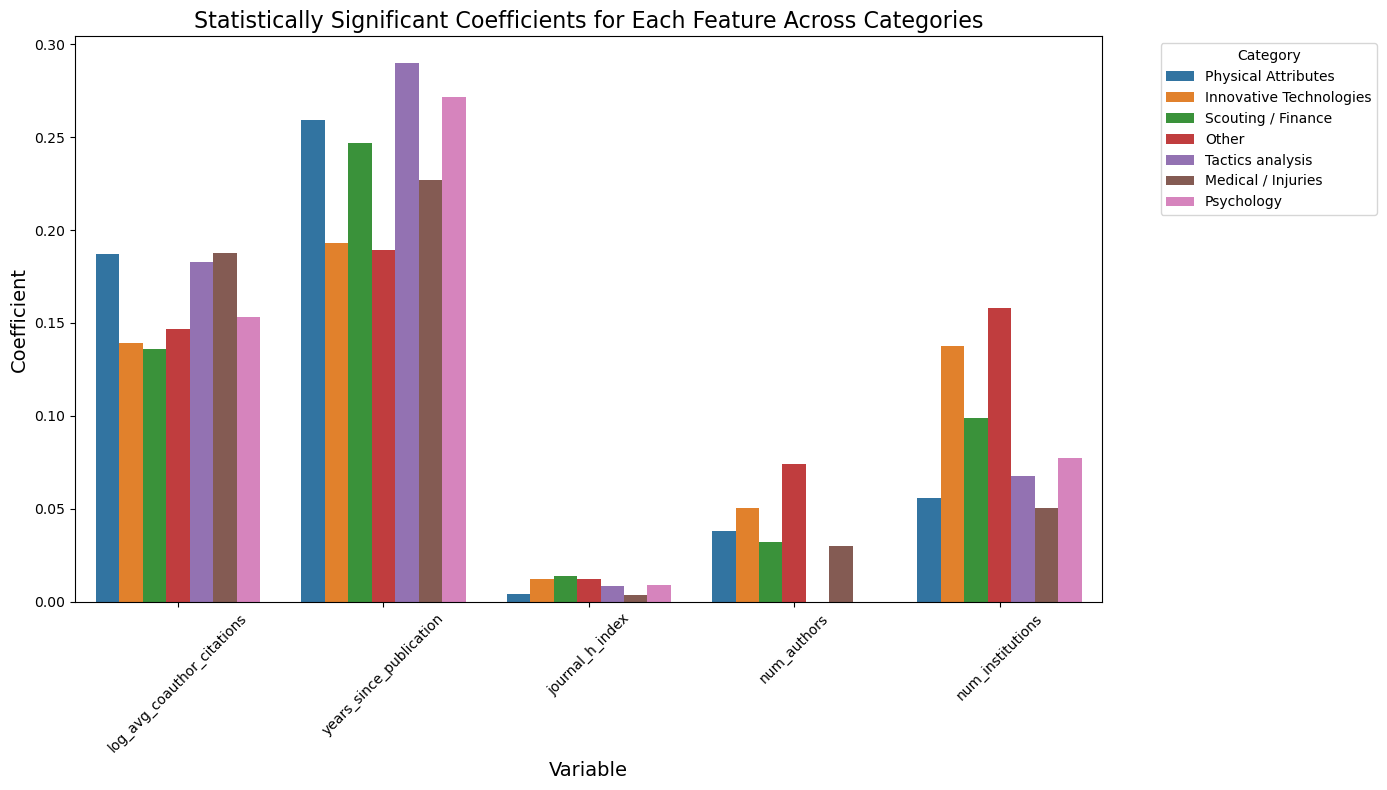

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Prepare a DataFrame for visualization from category_results
visualization_data = []

# Iterate over category_results to extract coefficients and significance
for category, results in category_results.items():
    for variable in ["log_avg_coauthor_citations", "years_since_publication", "journal_h_index", "num_authors", "num_institutions"]:
        coef = results.params.get(variable, 0)  # Extract coefficient
        p_value = results.pvalues.get(variable, 1)  # Extract p-value
        is_significant = p_value < 0.05  # Check if p-value indicates significance

        # Append only significant coefficients
        if is_significant:
            visualization_data.append({
                "Category": category,
                "Variable": variable,
                "Coefficient": coef
            })

# Convert to DataFrame for plotting
coef_melted_with_significance = pd.DataFrame(visualization_data)

# Plot only significant coefficients
plt.figure(figsize=(14, 8))

sns.barplot(
    data=coef_melted_with_significance,
    x="Variable",
    y="Coefficient",
    hue="Category",
    dodge=True,
    palette="tab10"  # Use distinct colors for categories
)

# Title and labels
plt.title("Statistically Significant Coefficients for Each Feature Across Categories", fontsize=16)
plt.xlabel("Variable", fontsize=14)
plt.ylabel("Coefficient", fontsize=14)
plt.xticks(rotation=45)
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

In [47]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Define the independent variables (X)
X = df[[
    "log_avg_coauthor_citations", 
    "years_since_publication", 
    "journal_h_index", 
    "num_authors", 
    "num_institutions"
]]
X = sm.add_constant(X)

# Calculate VIF for each variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

                     Variable       VIF
0                       const  5.833937
1  log_avg_coauthor_citations  1.421360
2     years_since_publication  1.021219
3             journal_h_index  1.268485
4                 num_authors  1.683486
5            num_institutions  1.768229


In [51]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
from collections import defaultdict
import ast

# Load the CSV file
file_path = 'data_export.csv'
df = pd.read_csv(file_path)

# Convert relevant columns to numeric and handle missing values
fields_to_convert = [
    "journal_h_index", "num_authors", "num_institutions",
    "cited_by_count", "publication_year", "avg_author_h_index", "max_author_h_index",
    "avg_institution_h_index", "max_institution_h_index", "avg_author_citations_past_5_years",
    "max_author_citations_past_5_years", "avg_institution_citations_past_5_years", 
    "max_institution_citations_past_5_years"
]
for field in fields_to_convert:
    df[field] = pd.to_numeric(df[field], errors="coerce").fillna(0)

# Drop rows where cited_by_count is 0
#df = df[df["cited_by_count"] > 0]

# Apply log transformation to cited_by_count
df["log_cited_by_count"] = np.log1p(df["cited_by_count"])  # log(1 + cited_by_count)

# Calculate time since publication
df["years_since_publication"] = 2024 - df["publication_year"]

# Default dictionaries to track publication and citation counts
author_publications = defaultdict(int)
author_citations = defaultdict(int)

# Calculate total publications and citations for each author
for _, row in df.iterrows():
    if pd.notna(row["authors"]):  # Process the "authors" field
        authors = ast.literal_eval(row["authors"]) if isinstance(row["authors"], str) else []
        for author in authors:
            author_publications[author] += 1
            author_citations[author] += row.get("cited_by_count", 0)

# Function to calculate average co-author citations excluding the focal paper
def calculate_coauthor_success(row):
    if pd.notna(row["authors"]):
        authors = ast.literal_eval(row["authors"]) if isinstance(row["authors"], str) else []
        coauthor_citations = [
            author_citations[author] - row["cited_by_count"]  # Exclude focal paper's citations
            for author in authors if author in author_citations
        ]
        if coauthor_citations:
            return sum(coauthor_citations) / len(coauthor_citations)
    return 0

# Add average co-author citations as a feature
df["avg_coauthor_citations"] = df.apply(calculate_coauthor_success, axis=1)

# Log-transform the average co-author citations to reduce skewness
df["log_avg_coauthor_citations"] = np.log1p(df["avg_coauthor_citations"])  # log(1 + avg_coauthor_citations)

# Define independent (X) and dependent (y) variables
X = df[[
    "log_avg_coauthor_citations", 
    "years_since_publication", 
    "journal_h_index", 
    "num_authors", 
    "num_institutions", 
    "avg_author_citations_past_5_years",
    "avg_institution_citations_past_5_years",
]]
y = df["log_cited_by_count"]

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Fit the OLS regression model
model = sm.OLS(y, X).fit()

# Print the summary of the regression model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     log_cited_by_count   R-squared:                       0.433
Model:                            OLS   Adj. R-squared:                  0.433
Method:                 Least Squares   F-statistic:                     1641.
Date:                Mon, 30 Dec 2024   Prob (F-statistic):               0.00
Time:                        12:39:39   Log-Likelihood:                -20778.
No. Observations:               15033   AIC:                         4.157e+04
Df Residuals:                   15025   BIC:                         4.163e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

In [53]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
from collections import defaultdict
import ast

# Load the CSV file
file_path = 'data_export.csv'
df = pd.read_csv(file_path)

# Convert relevant columns to numeric and handle missing values
fields_to_convert = [
    "journal_h_index", "num_authors", "num_institutions",
    "cited_by_count", "publication_year", "avg_author_h_index", "max_author_h_index",
    "avg_institution_h_index", "max_institution_h_index", "avg_author_citations_past_5_years",
    "max_author_citations_past_5_years", "avg_institution_citations_past_5_years", 
    "max_institution_citations_past_5_years"
]
for field in fields_to_convert:
    df[field] = pd.to_numeric(df[field], errors="coerce").fillna(0)

# Drop rows where cited_by_count is 0
df = df[df["cited_by_count"] > 0]

# Apply log transformation to cited_by_count
df["log_cited_by_count"] = np.log1p(df["cited_by_count"])  # log(1 + cited_by_count)

# Calculate time since publication
df["years_since_publication"] = 2024 - df["publication_year"]

# Default dictionaries to track publication and citation counts
author_publications = defaultdict(int)
author_citations = defaultdict(int)

# Calculate total publications and citations for each author
for _, row in df.iterrows():
    if pd.notna(row["authors"]):  # Process the "authors" field
        authors = ast.literal_eval(row["authors"]) if isinstance(row["authors"], str) else []
        for author in authors:
            author_publications[author] += 1
            author_citations[author] += row.get("cited_by_count", 0)

# Function to calculate average co-author citations excluding the focal paper
def calculate_coauthor_success(row):
    if pd.notna(row["authors"]):
        authors = ast.literal_eval(row["authors"]) if isinstance(row["authors"], str) else []
        coauthor_citations = [
            author_citations[author] - row["cited_by_count"]  # Exclude focal paper's citations
            for author in authors if author in author_citations
        ]
        if coauthor_citations:
            return sum(coauthor_citations) / len(coauthor_citations)
    return 0

# Add average co-author citations as a feature
df["avg_coauthor_citations"] = df.apply(calculate_coauthor_success, axis=1)

# Log-transform the average co-author citations to reduce skewness
df["log_avg_coauthor_citations"] = np.log1p(df["avg_coauthor_citations"])  # log(1 + avg_coauthor_citations)

# Extract unique predicted_category labels
categories = df["predicted_category"].dropna().unique()

# Initialize a dictionary to store results
category_results = {}

# Run the regression for each predicted category
for category in categories:
    # Filter the data for the current category
    df_category = df[df["predicted_category"] == category]
    
    # Ensure there is enough data to run regression
    if len(df_category) < 2:
        continue  # Skip if there isn't enough data for the category

    # Define independent (X) and dependent (y) variables
    X_cat = df_category[[
        "log_avg_coauthor_citations", 
        "years_since_publication", 
        "journal_h_index", 
        "num_authors", 
        "num_institutions", 
        "avg_author_citations_past_5_years",
        "avg_institution_citations_past_5_years",
    ]]
    y_cat = df_category["log_cited_by_count"]

    # Add a constant term to the independent variables
    X_cat = sm.add_constant(X_cat)

    # Fit the OLS regression model
    model_cat = sm.OLS(y_cat, X_cat).fit()

    # Store the regression results
    category_results[category] = model_cat

# Output the regression summaries for each category
for category, results in category_results.items():
    print(f"Category: {category}\n")
    print(results.summary())
    print("\n" + "="*80 + "\n")

Category: Physical Attributes

                            OLS Regression Results                            
Dep. Variable:     log_cited_by_count   R-squared:                       0.453
Model:                            OLS   Adj. R-squared:                  0.452
Method:                 Least Squares   F-statistic:                     445.7
Date:                Mon, 30 Dec 2024   Prob (F-statistic):               0.00
Time:                        12:42:15   Log-Likelihood:                -4309.5
No. Observations:                3779   AIC:                             8635.
Df Residuals:                    3771   BIC:                             8685.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

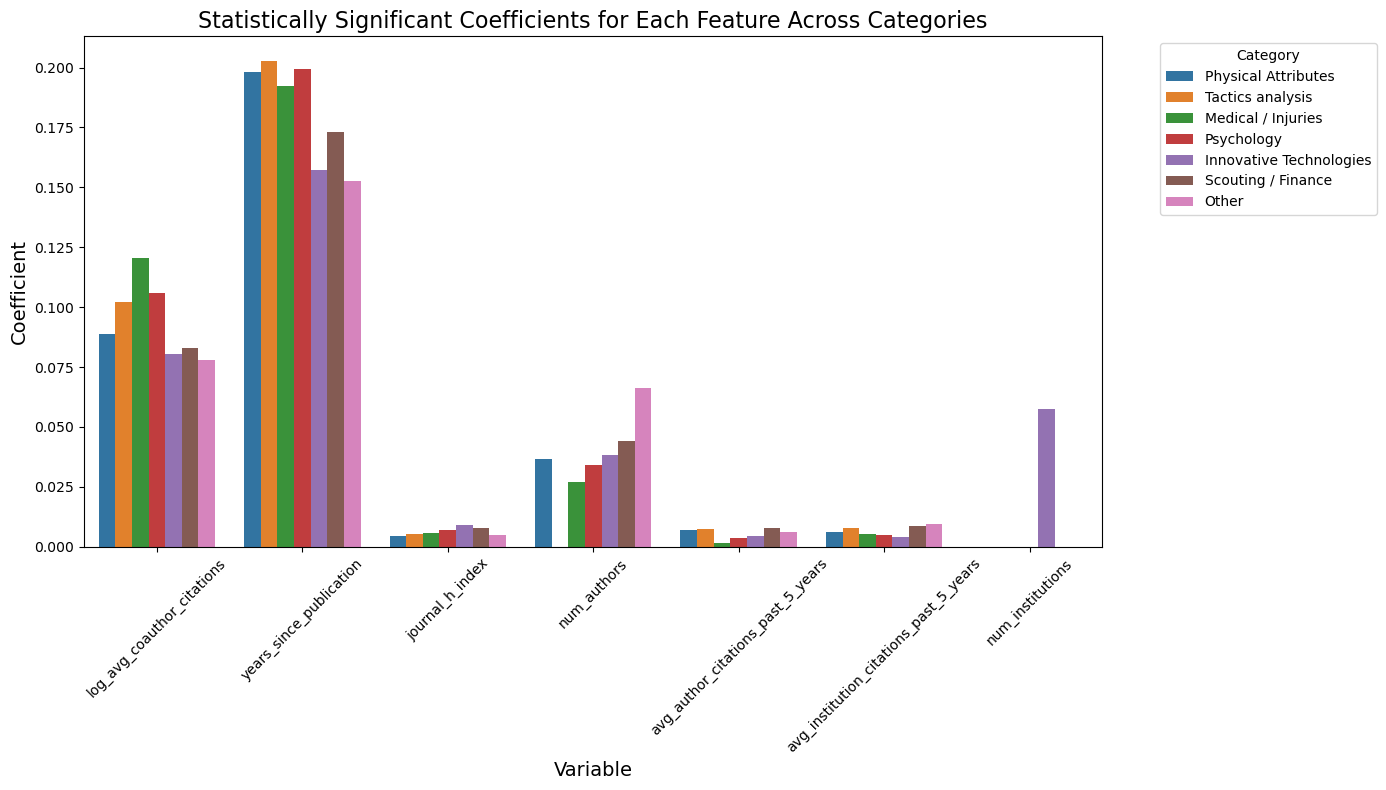

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Prepare a DataFrame for visualization from category_results
visualization_data = []

# Iterate over category_results to extract coefficients and significance
for category, results in category_results.items():
    for variable in [
        "log_avg_coauthor_citations", 
        "years_since_publication", 
        "journal_h_index", 
        "num_authors", 
        "num_institutions", 
        "avg_author_citations_past_5_years",
        "avg_institution_citations_past_5_years"
    ]:
        coef = results.params.get(variable, 0)  # Extract coefficient
        p_value = results.pvalues.get(variable, 1)  # Extract p-value
        is_significant = p_value < 0.05  # Check if p-value indicates significance

        # Append only significant coefficients
        if is_significant:
            visualization_data.append({
                "Category": category,
                "Variable": variable,
                "Coefficient": coef
            })

# Convert to DataFrame for plotting
coef_melted_with_significance = pd.DataFrame(visualization_data)

# Check if there is data to plot
if not coef_melted_with_significance.empty:
    # Plot only significant coefficients
    plt.figure(figsize=(14, 8))

    sns.barplot(
        data=coef_melted_with_significance,
        x="Variable",
        y="Coefficient",
        hue="Category",
        dodge=True,
        palette="tab10"  # Use distinct colors for categories
    )

    # Title and labels
    plt.title("Statistically Significant Coefficients for Each Feature Across Categories", fontsize=16)
    plt.xlabel("Variable", fontsize=14)
    plt.ylabel("Coefficient", fontsize=14)
    plt.xticks(rotation=45)
    plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    plt.show()
else:
    print("No significant coefficients to plot.")

In [52]:
#THESE ARE ALL THE FEATURES FROM THE RANDOM FOREST REGRESSION - NOT ALL OF THEM ARE NECESSARY

# from statsmodels.stats.outliers_influence import variance_inflation_factor

# # Step 1: Define independent (X) and dependent (y) variables
# X = df[[
#     "log_avg_coauthor_citations", 
#     "years_since_publication", 
#     "journal_h_index", 
#     "num_authors", 
#     "num_institutions", 
#     "avg_author_citations_past_5_years",
#     "max_author_citations_past_5_years",
#     "avg_institution_citations_past_5_years",
#     "max_institution_citations_past_5_years"
# ]]
# y = df["log_cited_by_count"]

# # Add a constant term
# X = sm.add_constant(X)

# # Step 2: Calculate VIF and remove high VIF features iteratively
# def calculate_vif(X):
#     vif_data = pd.DataFrame()
#     vif_data["Variable"] = X.columns
#     vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
#     return vif_data

# # Initial VIF calculation
# vif_data = calculate_vif(X)

# # Iteratively drop variables with high VIF
# while vif_data["VIF"].max() > 5:  # You can change the threshold to 10 if appropriate
#     high_vif_variable = vif_data.loc[vif_data["VIF"].idxmax(), "Variable"]
#     if high_vif_variable == "const":
#         break  # Do not drop the constant term
#     print(f"Dropping {high_vif_variable} due to high VIF ({vif_data['VIF'].max():.2f})")
#     X = X.drop(columns=[high_vif_variable])
#     vif_data = calculate_vif(X)

# # Step 3: Fit the OLS regression model with the reduced set of variables
# model = sm.OLS(y, X).fit()

# # Print the summary of the improved regression model
# print(model.summary())

# # Step 4: Recalculate VIF for the reduced model
# vif_data_final = calculate_vif(X)
# print("Final VIF values:")
# print(vif_data_final)

# # Step 5: Analyze the new model

                            OLS Regression Results                            
Dep. Variable:     log_cited_by_count   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                     1298.
Date:                Mon, 30 Dec 2024   Prob (F-statistic):               0.00
Time:                        12:39:40   Log-Likelihood:                -20725.
No. Observations:               15033   AIC:                         4.147e+04
Df Residuals:                   15023   BIC:                         4.155e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------